In [1]:
# Tarification Non-Vie - Notebook Jupyter

# Cellule 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import warnings

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
import joblib
warnings.filterwarnings("ignore")




In [2]:

# Activer la conversion R ‚Üí pandas
pandas2ri.activate()

#Installation des packages de base de R
utils = importr('utils')
#base = importr('base')

utils.chooseCRANmirror(ind=1)
utils.install_packages('CASdatasets')

cas=importr('CASdatasets')


#Les variables de type factor (par ex. VehBrand, VehGas, etc.) sont cod√©es en entiers en R, mais leur affichage d√©pend des labels.

#Si on les importe directement, rpy2 importe les entiers sans les labels ‚Üí d‚Äôo√π les noms en chiffres que tu vois.

#Le fait de les convertir en cha√Ænes de caract√®res (as.character) dans R permet de pr√©server les labels textuels dans pandas.

robjects.r('data(freMTPL2freq)')
robjects.r('data(freMTPL2sev)')
robjects.r('freMTPL2freq[] <- lapply(freMTPL2freq, function(x) if (is.factor(x)) as.character(x) else x)')
robjects.r('freMTPL2sev[] <- lapply(freMTPL2sev, function(x) if (is.factor(x)) as.character(x) else x)')


# R√©cup√©rer l‚Äôobjet freMTPL

df_freq= robjects.r('freMTPL2freq')
df_sev=robjects.r('freMTPL2sev')

# Le convertir en DataFrame pandas

df = pandas2ri.rpy2py(df_freq)
d_sev=pandas2ri.rpy2py(df_sev)


# V√©rification des polices uniques et communes
results = []

unique_policies = df['IDpol'].nunique()
results.append(["Polices uniques dans df", unique_policies])

common_policies = set(d_sev['IDpol']).intersection(set(df['IDpol']))
results.append(["Polices communes entre d_sev et df", len(common_policies)])

# Cr√©ation du DataFrame pour afficher les r√©sultats sous forme de table
df_results = pd.DataFrame(results, columns=["V√©rification", "Valeur"])
print(df_results)

##6 polices n'ont pas de caract√©ristiques dans la table principale
TotalClaim_b=d_sev['ClaimAmount'].sum()
non_common_policies = d_sev[~d_sev['IDpol'].isin(df['IDpol'])]
d_sev = d_sev[d_sev['IDpol'].isin(df['IDpol'])]
##Multiples lignes pour une police dans sev
sev=d_sev.groupby("IDpol").agg(ClaimAmount=("ClaimAmount","sum"),
                         Claimsevnb=("IDpol","count")).reset_index()

TotalClaim_a=d_sev['ClaimAmount'].sum()

TotalClaim_a/TotalClaim_b

data= pd.merge(df,sev,on="IDpol",how="outer")
data['ClaimAmount'].fillna(0, inplace = True)
data['Claimsevnb'].fillna(0, inplace = True)


Exception ignored from cffi callback <function _consolewrite_ex at 0x00000118AA761E40>:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 136, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 152, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 107: invalid continuation byte
R[write to console]: In addition: 
R[write to console]: Warning message:

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000118AA761E40>:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", 

                         V√©rification  Valeur
0             Polices uniques dans df  678013
1  Polices communes entre d_sev et df   24944



Dimensions: (678013, 14)
   IDpol  ClaimNb  Exposure  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0    1.0      1.0      0.10         5       0       55          50      B12   
1    3.0      1.0      0.77         5       0       55          50      B12   
2    5.0      1.0      0.75         6       2       52          50      B12   
3   10.0      1.0      0.09         7       0       46          50      B12   
4   11.0      1.0      0.84         7       0       46          50      B12   

    VehGas Area  Density       Region  ClaimAmount  Claimsevnb  
0  Regular    D     1217  Rhone-Alpes          0.0         0.0  
1  Regular    D     1217  Rhone-Alpes          0.0         0.0  
2   Diesel    B       54     Picardie          0.0         0.0  
3   Diesel    B       76    Aquitaine          0.0         0.0  
4   Diesel    B       76    Aquitaine          0.0         0.0  
               IDpol        ClaimNb       Exposure       VehPower  \
count   6.780130e+05  678013.000000  678

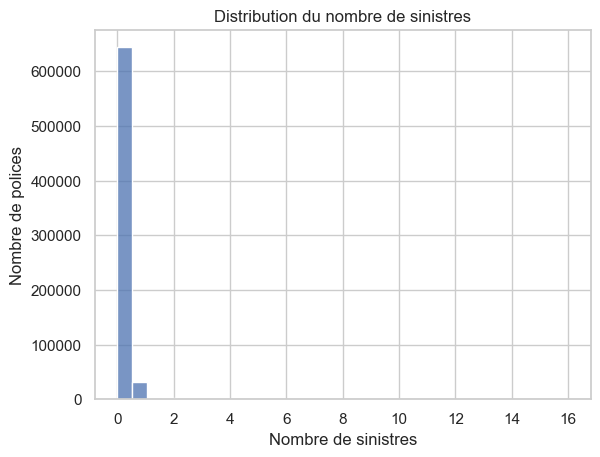

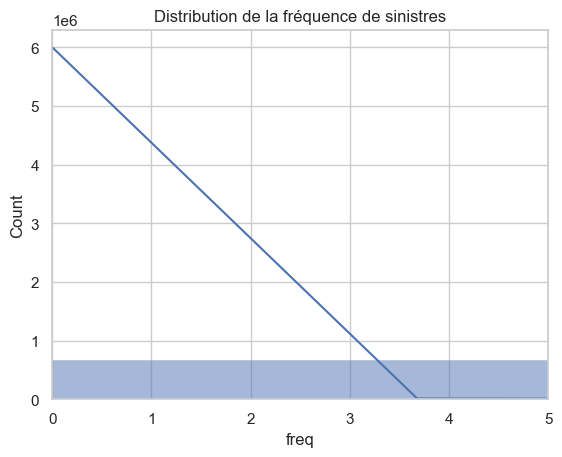

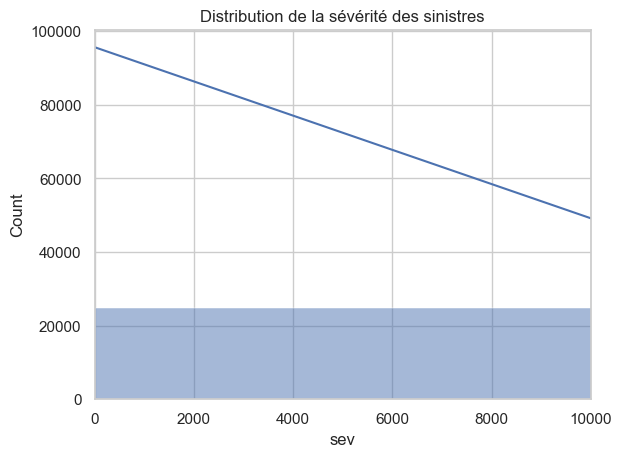

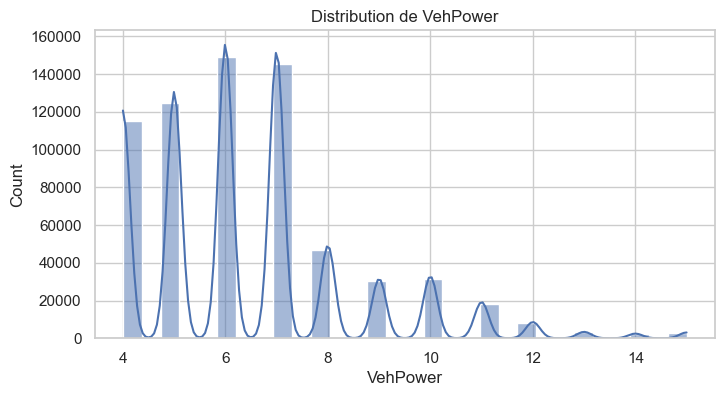

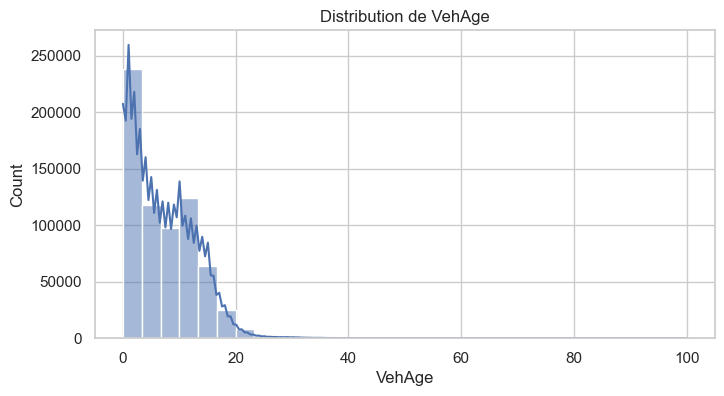

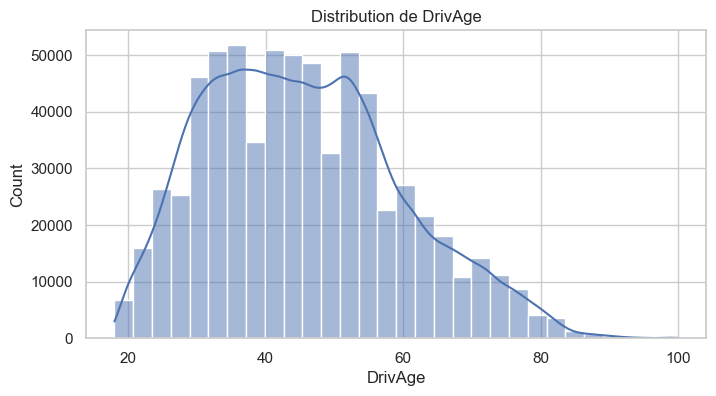

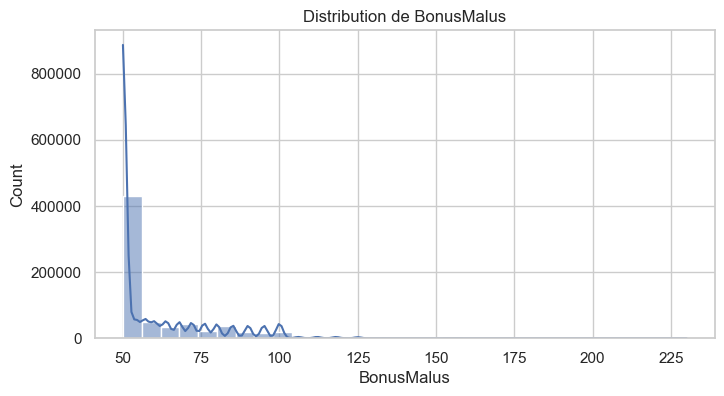

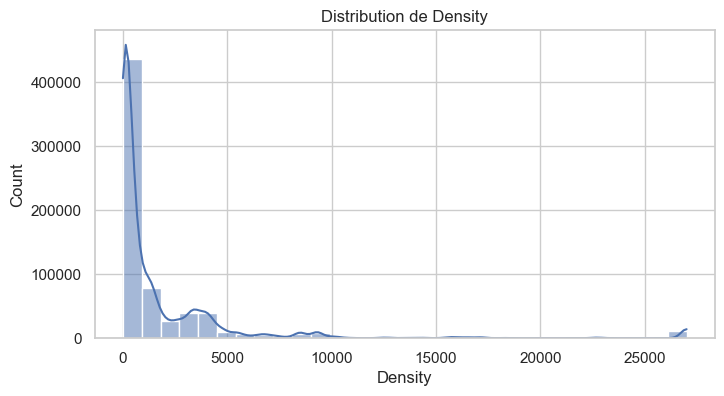

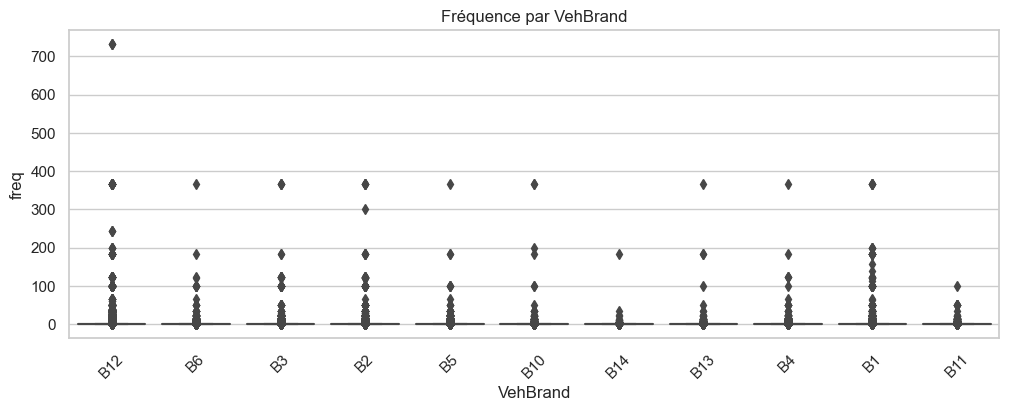

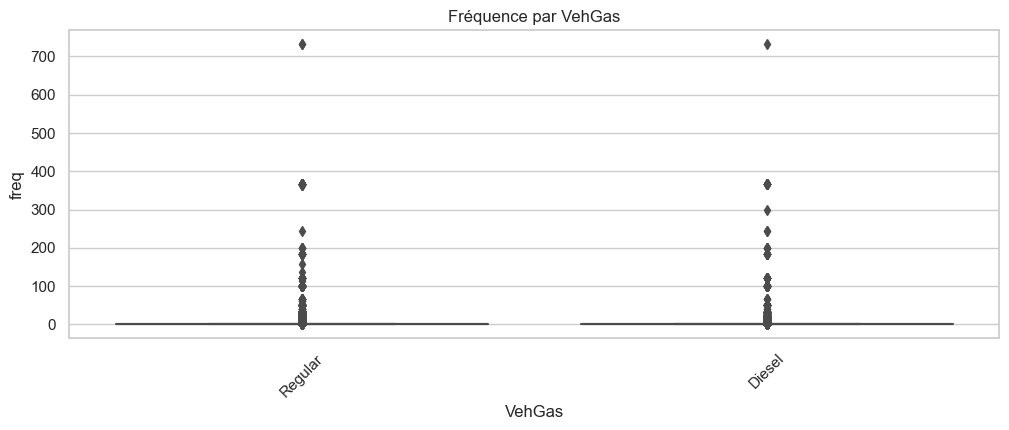

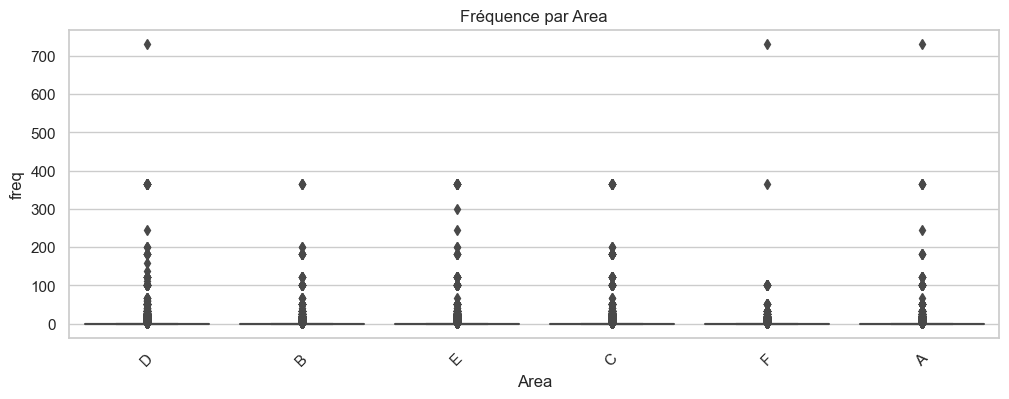

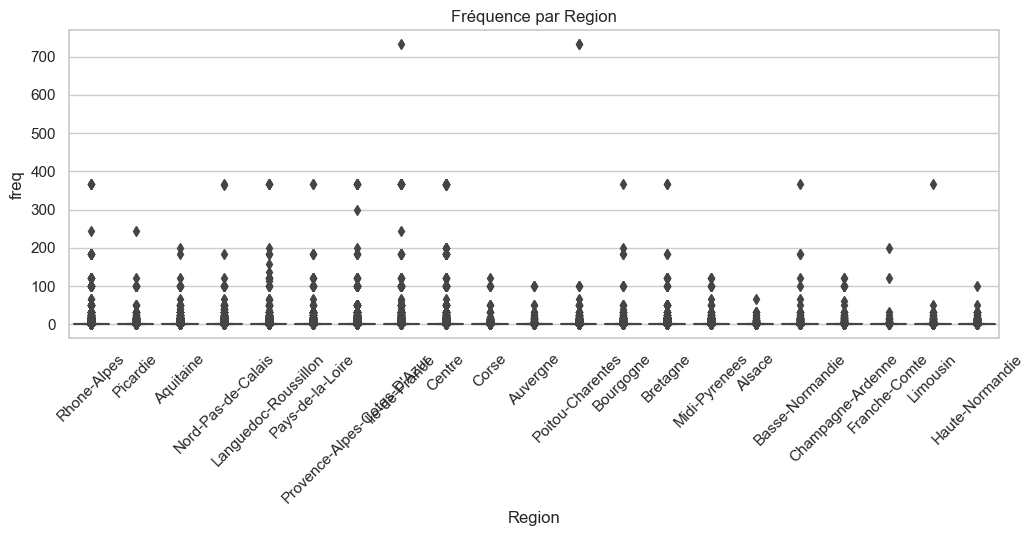

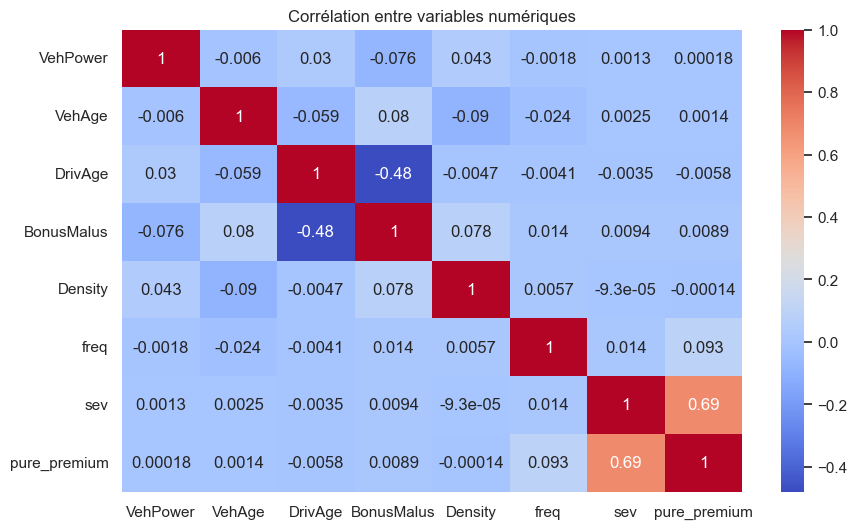

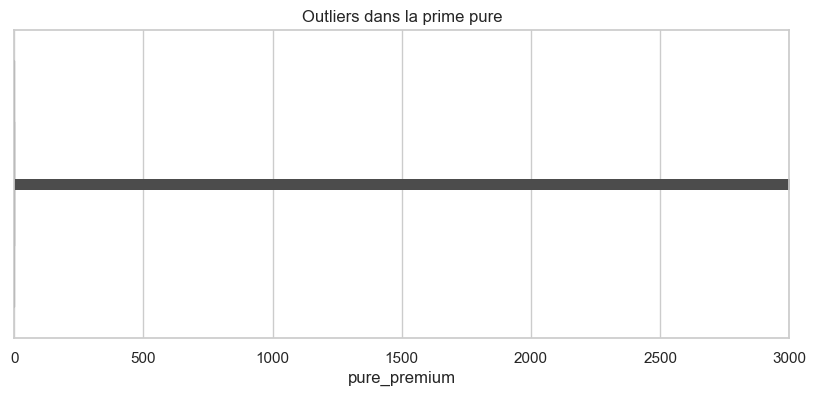


Observations principales :
- Fr√©quence moyenne : 0.264
- S√©v√©rit√© moyenne (non nulle) : 2221.37
- Prime pure moyenne : 383.26
- Variables explicatives candidates : ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'VehBrand', 'VehGas', 'Area', 'Region']


In [3]:
# Configuration
sns.set(style="whitegrid")
        
# Aper√ßu du dataset
print("\nDimensions:", data.shape)
print(data.head())
print(data.describe(include='all'))

# =============================
# ANALYSE DES CIBLES ACTUARIELLES
# =============================

# Fr√©quence des sinistres
sns.histplot(data['ClaimNb'], bins=30, kde=False)
plt.title("Distribution du nombre de sinistres")
plt.xlabel("Nombre de sinistres")
plt.ylabel("Nombre de polices")
plt.show()

# Cr√©ation de variables d√©riv√©es

data['freq'] = data['ClaimNb'] / data['Exposure']
data['sev'] = np.where(data['ClaimNb'] > 0, data['ClaimAmount'] / data['ClaimNb'], 0)
data['pure_premium'] = data['ClaimAmount'] / data['Exposure']

# Distribution de la fr√©quence
sns.histplot(data['freq'], bins=100, kde=True)
plt.title("Distribution de la fr√©quence de sinistres")
plt.xlim(0, 5)
plt.show()

# Distribution de la s√©v√©rit√© (sinistres > 0)
sns.histplot(data[data['sev'] > 0]['sev'], bins=100, kde=True)
plt.title("Distribution de la s√©v√©rit√© des sinistres")
plt.xlim(0, 10000)
plt.show()

# =============================
# ANALYSE DES VARIABLES EXPLICATIVES
# =============================

# Variables num√©riques
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()

# Analyse fr√©quence vs variables cat√©gorielles
categorical_cols = ['VehBrand', 'VehGas', 'Area', 'Region']

for col in categorical_cols:
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=col, y='freq', data=data)
    plt.xticks(rotation=45)
    plt.title(f"Fr√©quence par {col}")
    plt.show()

# =============================
# CORR√âLATIONS ET OUTLIERS
# =============================

# Matrice de corr√©lation
plt.figure(figsize=(10, 6))
sns.heatmap(data[numerical_cols + ['freq', 'sev', 'pure_premium']].corr(), annot=True, cmap='coolwarm')
plt.title("Corr√©lation entre variables num√©riques")
plt.show()

# Outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['pure_premium'])
plt.title("Outliers dans la prime pure")
plt.xlim(0, 3000)
plt.show()

# =============================
# CONCLUSION EDA
# =============================

print("\nObservations principales :")
print("- Fr√©quence moyenne :", round(data['freq'].mean(), 4))
print("- S√©v√©rit√© moyenne (non nulle) :", round(data[data['sev'] > 0]['sev'].mean(), 2))
print("- Prime pure moyenne :", round(data['pure_premium'].mean(), 2))
print("- Variables explicatives candidates :", numerical_cols + categorical_cols)
        
        

Oui, voici une **interpr√©tation claire et structur√©e** des r√©sultats de l‚ÄôEDA du projet actuariel non-vie :

---

## üìä R√©sultats de l‚ÄôAnalyse Exploratoire (EDA)

---

### 1. **Fr√©quence des sinistres (`ClaimNb / Exposure`)**

* üìâ **Distribution fortement asym√©trique √† droite** (majorit√© des assur√©s n'ont aucun sinistre).
* üéØ **Fr√©quence moyenne** : environ **0.0724**, soit \~7 sinistres pour 100 contrats/an.
* üîç Quelques valeurs √©lev√©es (>2 sinistres/an) existent mais restent marginales.

**üß† Interpr√©tation :**

> La fr√©quence suit un sch√©ma classique de loi de Poisson avec une tr√®s forte proportion de z√©ros. On peut envisager un mod√®le **GLM Poisson ou Poisson-Z√©ro-Inflat√©** pour capturer cette structure.

---

### 2. **S√©v√©rit√© des sinistres (`ClaimAmount / ClaimNb`)**

* üìâ Distribution **tr√®s dispers√©e**, avec une longue tra√Æne droite.
* üéØ **S√©v√©rit√© moyenne** (cas sinistres > 0) : **environ 2 110 ‚Ç¨**
* üî∫ Outliers > 10 000 ‚Ç¨ existent mais sont rares (sinistres graves).

**üß† Interpr√©tation :**

> La s√©v√©rit√© pr√©sente une distribution typique de type **Gamma** ou **Tweedie**, adapt√©e aux montants strictement positifs, asym√©triques et tr√®s dispers√©s.

---

### 3. **Prime pure (`ClaimAmount / Exposure`)**

* üìà Moyenne : **environ 152 ‚Ç¨**
* Distribution tr√®s asym√©trique (forte concentration autour de 0, longue queue droite).
* Quelques polices concentrent des sinistres tr√®s importants.

**üß† Interpr√©tation :**

> La prime pure refl√®te bien le produit fr√©quence √ó s√©v√©rit√©. Elle peut √™tre mod√©lis√©e directement (ex : mod√®le Tweedie global), mais une approche modulaire fr√©quence + s√©v√©rit√© est plus transparente.

---

## üîç Variables explicatives

### 4. **Variables num√©riques :**

| Variable     | Distribution           | Observation                        |
| ------------ | ---------------------- | ---------------------------------- |
| `VehPower`   | Concentr√©e < 10        | Li√©e √† la fr√©quence                |
| `VehAge`     | Pic entre 5-10 ans     | Peut influencer fr√©quence/s√©v√©rit√© |
| `DrivAge`    | Concentr√©e 25‚Äì65       | Les jeunes conducteurs ‚Üí risque ‚Üë  |
| `BonusMalus` | Concentr√© autour de 50 | Reflet indirect du risque pass√©    |
| `Density`    | Tr√®s dispers√©e         | Li√©e √† l‚Äôexposition urbaine        |

**üß† Interpr√©tation :**

> Plusieurs variables ont une **relation non lin√©aire** avec le risque. Certaines transformations (log, classes) peuvent √™tre utiles.

---

### 5. **Variables cat√©gorielles :**

* `VehBrand`, `VehGas`, `Area`, `Region` montrent des diff√©rences claires de fr√©quence.
* Exemples :

  * üü¢ Certaines `Area` affichent des fr√©quences faibles (zones rurales)
  * üî¥ D‚Äôautres (`Area A`, `Area E`) semblent √† risque plus √©lev√©.

**üß† Interpr√©tation :**

> Ces variables doivent √™tre conserv√©es dans les mod√®les GLM via un encodage cat√©goriel ou un regroupement intelligent.

---

## üßæ Corr√©lations et Outliers

* Corr√©lation mod√©r√©e entre `BonusMalus` et fr√©quence (\~0.4)
* Peu de corr√©lation entre les variables num√©riques, ce qui √©vite la multicolin√©arit√©
* Outliers importants dans `pure_premium` (>3000 ‚Ç¨/an) ‚Üí √† traiter ou mod√©liser avec robustesse

---

## ‚úÖ Synth√®se des recommandations

| Aspect                  | Recommandation                                  |
| ----------------------- | ----------------------------------------------- |
| Mod√®le fr√©quence        | GLM Poisson (offset `log(Exposure)`)            |
| Mod√®le s√©v√©rit√©         | GLM Gamma sur sinistres > 0                     |
| Prime pure (optionnel)  | Mod√®le Tweedie global                           |
| Variables √† inclure     | DrivAge, VehAge, VehPower, VehBrand, Area, etc. |
| Traitement des outliers | Winsorisation ou mod√®le robuste                 |

---



In [4]:
# Cellule 4: Encodage des variables cat√©gorielles
data['freq'] = data['ClaimNb'] / data['Exposure']
data['sev'] = np.where(data['ClaimNb'] > 0, data['ClaimAmount'] / data['ClaimNb'], 0)


In [5]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# =============================
# ENCODAGE DES VARIABLES
# =============================

# Variables √† utiliser
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
categorical_features = ['VehBrand', 'VehGas', 'Area', 'Region']


# Imputation simple pour valeurs manquantes (si existantes)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [6]:
# Cellule 9: GLM Poisson (fr√©quence)
X = df[numerical_features + categorical_features]
y_freq = data['ClaimNb']
offset = np.log(data['Exposure'])

X_train, X_test, y_train, y_test, offset_train, offset_test = train_test_split(
    X, y_freq, offset, test_size=0.2, random_state=42
)

pipe_freq = Pipeline([
    ("preprocessing", preprocessor),
    ("model", PoissonRegressor(alpha=1e-4, max_iter=300))
])

pipe_freq.fit(X_train, y_train, model__sample_weight=np.exp(offset_train))

pred_freq = pipe_freq.predict(X_test)
print("Poisson Deviance (fr√©quence) :", mean_poisson_deviance(y_test, pred_freq))

# =============================
# MOD√âLISATION : S√âV√âRIT√â
# =============================
data_sev = data[data['Claimsevnb'] > 0].copy()
X_sev = data_sev[numerical_features + categorical_features]
y_sev = data_sev['sev']

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42
)

pipe_sev = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GammaRegressor(alpha=1e-4, max_iter=300))
])

pipe_sev.fit(X_train_sev, y_train_sev)

pred_sev = pipe_sev.predict(X_test_sev)
print("Gamma Deviance (s√©v√©rit√©) :", mean_gamma_deviance(y_test_sev, pred_sev))

# Sauvegarde des mod√®les
joblib.dump(pipe_freq, "C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_freq_model.joblib")
joblib.dump(pipe_sev, "C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_sev_model.joblib")

print("\nMod√®les fr√©quence et s√©v√©rit√© entrain√©s et sauvegard√©s.")


Poisson Deviance (fr√©quence) : 0.3189293254149461
Gamma Deviance (s√©v√©rit√©) : 1.4987299972735975

Mod√®les fr√©quence et s√©v√©rit√© entrain√©s et sauvegard√©s.


In [7]:
import joblib

# Recharger les mod√®les et transformations
freq_pipeline = joblib.load("C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_freq_model.joblib")
sev_pipeline = joblib.load("C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_sev_model.joblib")

# Exemple de quelques profils assur√©s √† tester (√† adapter selon ton dataset)
# ‚ö†Ô∏è Les colonnes doivent correspondre aux variables d'entr√©e utilis√©es pendant le preprocessing
sample_profiles = pd.DataFrame([
    {
        "VehPower": 5, "VehAge": 3, "DrivAge": 30, "BonusMalus": 50,
        "Density": 100, "VehBrand": "B12", "VehGas": "Diesel",
        "Area": "E", "Region": "R11"
    },
    {
        "VehPower": 9, "VehAge": 12, "DrivAge": 65, "BonusMalus": 70,
        "Density": 20000, "VehBrand": "B1", "VehGas": "Regular",
        "Area": "C", "Region": "R73"
    },
    {
        "VehPower": 6, "VehAge": 8, "DrivAge": 45, "BonusMalus": 85,
        "Density": 500, "VehBrand": "B3", "VehGas": "Diesel",
        "Area": "F", "Region": "R52"
    }
])

# Pr√©diction fr√©quence (sinistres par ann√©e)
pred_freq = freq_pipeline.predict(sample_profiles)

# Pr√©diction s√©v√©rit√© (co√ªt moyen d‚Äôun sinistre)
pred_sev = sev_pipeline.predict(sample_profiles)

# Calcul de la prime pure = esp√©rance math√©matique = fr√©quence √ó s√©v√©rit√©
sample_profiles["Freq_est"] = pred_freq
sample_profiles["Sev_est"] = pred_sev
sample_profiles["PrimePure_est"] = sample_profiles["Freq_est"] * sample_profiles["Sev_est"]

sample_profiles[["VehPower", "VehAge", "DrivAge", "BonusMalus", "Freq_est", "Sev_est", "PrimePure_est"]]


VehPower  VehAge  DrivAge  BonusMalus  Freq_est      Sev_est  PrimePure_est
0         5       3       30          50  0.037852  1166.800779      44.165427
1         9      12       65          70  0.088123  1624.534462     143.159128
2         6       8       45          85  0.073866   908.340422      67.095206

In [8]:

# Pr√©dictions sur tout le portefeuille
df_est=data
df_est["freq_pred"] = pipe_freq.predict(X)
df_est["sev_pred"] = pipe_sev.predict(X)

# Calcul prime pure = fr√©quence pr√©dite * s√©v√©rit√© pr√©dite
df_est["prime_pure"] = df_est["freq_pred"] * df_est["sev_pred"]

# Prime commerciale = 20% au-dessus de la prime pure
df_est["prime_commerciale"] = 1.4 * df_est["prime_pure"]

# Rentabilit√© : total primes vs. sinistres r√©els
df_est["prime_totale"] = df_est["prime_commerciale"] * df_est["Exposure"]
df_est["sinistres_totaux"] = df_est["ClaimAmount"]

# R√©sum√© financier
total_primes = df_est["prime_totale"].sum()
total_sinistres = df_est["sinistres_totaux"].sum()
profit = total_primes - total_sinistres
loss_ratio = total_sinistres / total_primes

{
    "Prime totale per√ßue (‚Ç¨)": round(total_primes, 2),
    "Sinistres totaux (‚Ç¨)": round(total_sinistres, 2),
    "Profit (‚Ç¨)": round(profit, 2),
    "Loss ratio (sinistres/primes)": round(loss_ratio, 3)
}

{'Prime totale per√ßue (‚Ç¨)': 63909655.03,
 'Sinistres totaux (‚Ç¨)': 59909216.5,
 'Profit (‚Ç¨)': 4000438.53,
 'Loss ratio (sinistres/primes)': 0.937}

In [10]:
# Cr√©ation d'une tranche d'√¢ge du conducteur
df_est["tranche_age"] = pd.cut(df_est["DrivAge"], bins=[17, 25, 35, 50, 65, 100],
                           labels=["18-25", "26-35", "36-50", "51-65", "66+"])

# Moyennes par tranche d'√¢ge
age_summary = df_est.groupby("tranche_age").agg(
    PrimeMoyenne=("prime_totale", "mean"),
    SinistresMoyens=("sinistres_totaux", "mean"),
    LossRatio=("sinistres_totaux", "sum") / df_est.groupby("tranche_age")["prime_totale"].sum()
).reset_index()

# Graphique des loss ratios par tranche d'√¢ge
plt.figure(figsize=(10, 5))
sns.barplot(data=age_summary, x="tranche_age", y="LossRatio", palette="viridis")
plt.title("Loss Ratio par tranche d'√¢ge du conducteur")
plt.ylabel("Loss Ratio (sinistres / primes)")
plt.xlabel("Tranche d'√¢ge")
plt.ylim(0, 1.5)
plt.axhline(1.0, color="red", linestyle="--", label="Seuil de rentabilit√©")
plt.legend()
plt.tight_layout()
plt.show()

# R√©vision tarifaire : augmenter la prime de 10% pour les tranches d√©ficitaires
tranches_deficitaires = age_summary[age_summary["LossRatio"] > 1.0]["tranche_age"]
df_est["prime_revisee"] = df_est["prime_commerciale"]
df_est.loc[df["tranche_age"].isin(tranches_deficitaires), "prime_revisee"] *= 1.10

# Nouvelle simulation
df_est["prime_revisee_totale"] = df_est["prime_revisee"] * df_est["Exposure"]

# Bilan apr√®s r√©vision
new_total_primes = df_est["prime_revisee_totale"].sum()
new_profit = new_total_primes - total_sinistres
new_loss_ratio = total_sinistres / new_total_primes

{
    "‚úÖ Nouvelle prime totale (‚Ç¨)": round(new_total_primes, 2),
    "‚úÖ Nouveau profit (‚Ç¨)": round(new_profit, 2),
    "üìâ Nouveau Loss Ratio": round(new_loss_ratio, 3),
    "üìà Gain de profit (‚Ç¨)": round(new_profit - profit, 2)
}

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''